In [1]:
from mne import read_epochs, set_eeg_reference
from mne.decoding import CSP, UnsupervisedSpatialFilter
from mne.preprocessing import ICA, EOGRegression
import numpy as np
from mne.viz import plot_ica_components
from jupyterthemes.stylefx import set_nb_theme
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
set_nb_theme('gruvboxd')

Load and Preprocessing

In [18]:
import sys
sys.path.append('../../preprocessing')
from load_data import load_raw_to_epochs, get_channel_types

# load_raw_to_epochs('m.bdf', True)

In [32]:
raw = read_epochs('raw_epo.fif')

Reading C:\Users\Alberto\Documents\BCI\data\mrl\raw_epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    7999.02 ms
        0 CTF compensation matrices available
Not setting metadata
127 matching events found
No baseline correction applied
0 projection items activated


In [ ]:
raw.copy().filter(1,120, n_jobs=8).plot(n_channels=20, n_epochs=2, scalings=10e-5, events=raw.events, picks=['eeg','eog'])

Marking bad chanels

In [33]:
bads = ['T7', 'PO7', 'PO4', 'EXG8', 'EXG7', 'EXG6', 'FCz', 'FC2', 'FC3', 'F6', 'EXG5', 'C1', 'FC5', 'F1', 'P1', 'F4', 'Oz']
raw.info['bads'] = bads
raw.drop([2, 22,27, 31, 42, 48, 70, 90, 91, 99, 102, 107, 118, 119, 121])

Dropped 15 epochs: 2, 22, 27, 31, 42, 48, 70, 90, 91, 99, 102, 107, 118, 119, 121


<EpochsFIF |  112 events (all good), -2 - 7.99902 sec, baseline off, ~638.9 MB, data loaded,
 'r_pinch': 25
 'r_stop': 24
 'left': 24
 'right': 22
 'rest': 17>

Referencing

In [34]:
referenced = set_eeg_reference(raw,ref_channels='average')[0]
del raw

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


set channel types

In [35]:
referenced.set_channel_types(get_channel_types())

<EpochsFIF |  112 events (all good), -2 - 7.99902 sec, baseline off, ~638.9 MB, data loaded,
 'r_pinch': 25
 'r_stop': 24
 'left': 24
 'right': 22
 'rest': 17>

Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 5776 tasks      | elapsed:    8.3s
[Parallel(n_jobs=8)]: Done 7232 out of 7232 | elapsed:    9.5s finished


Using matplotlib as 2D backend.


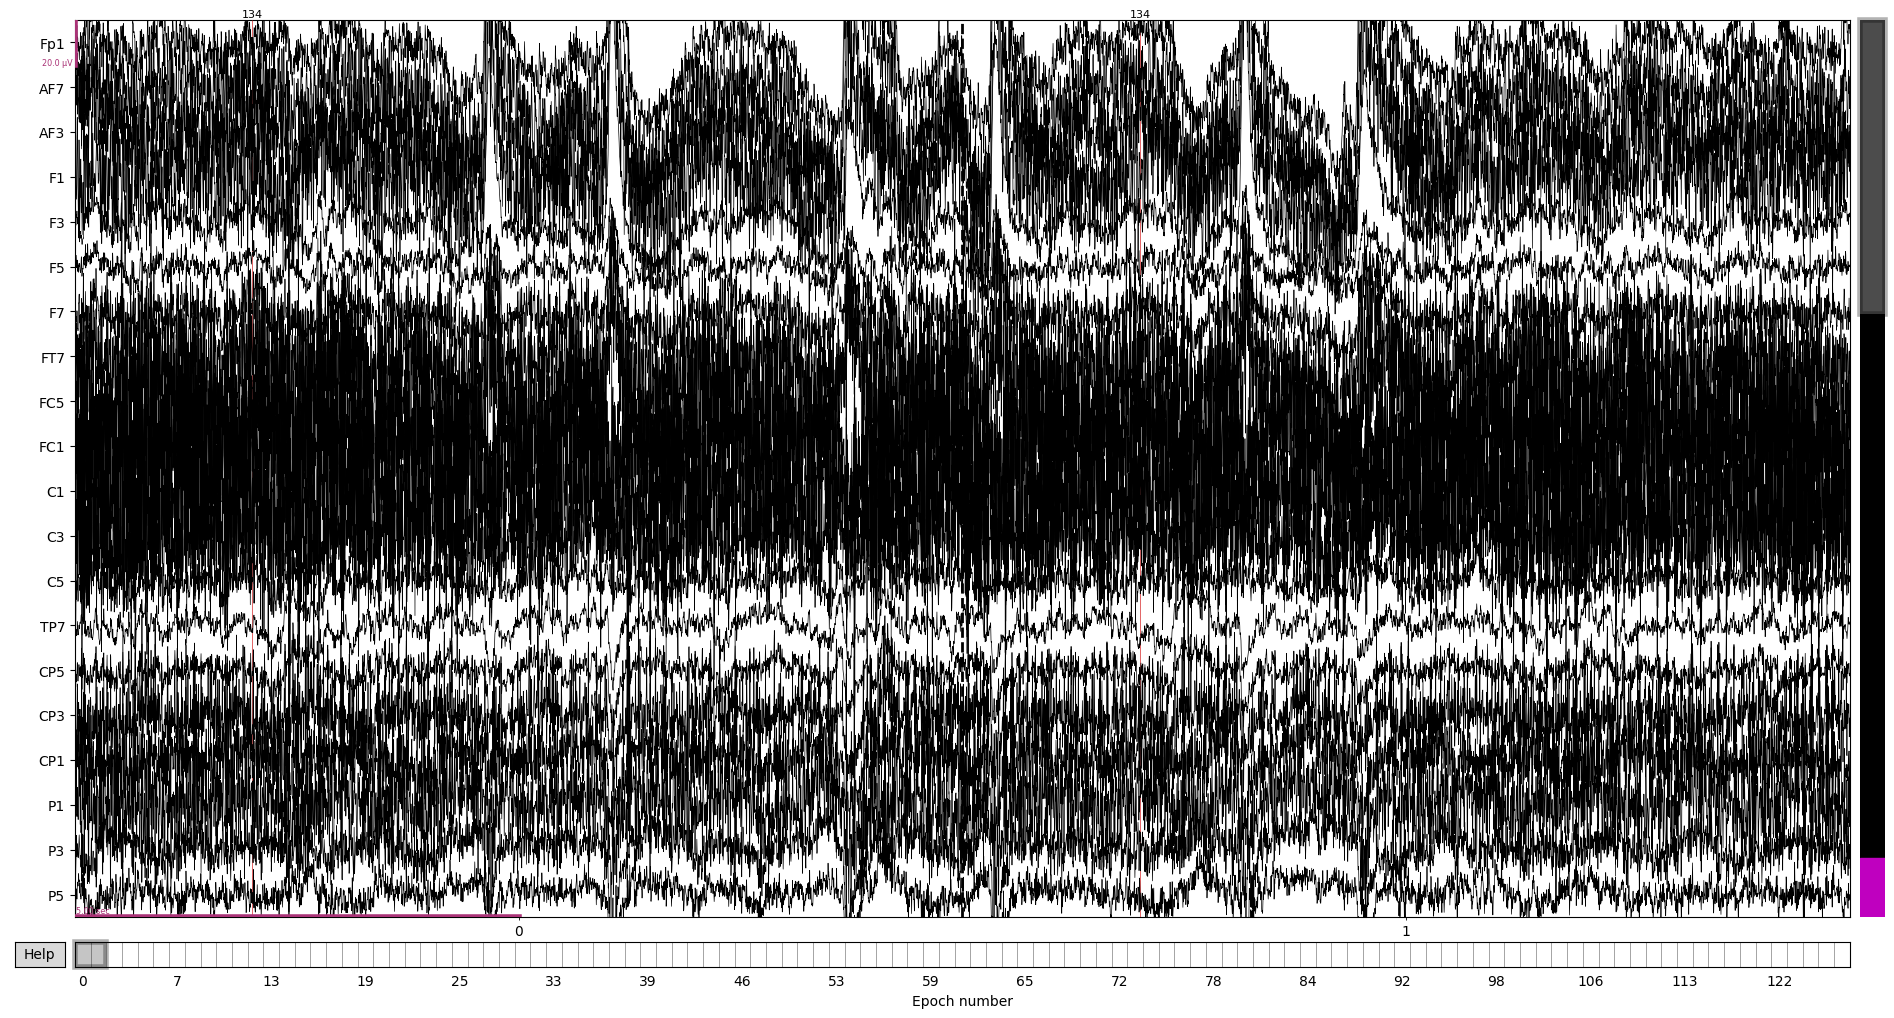

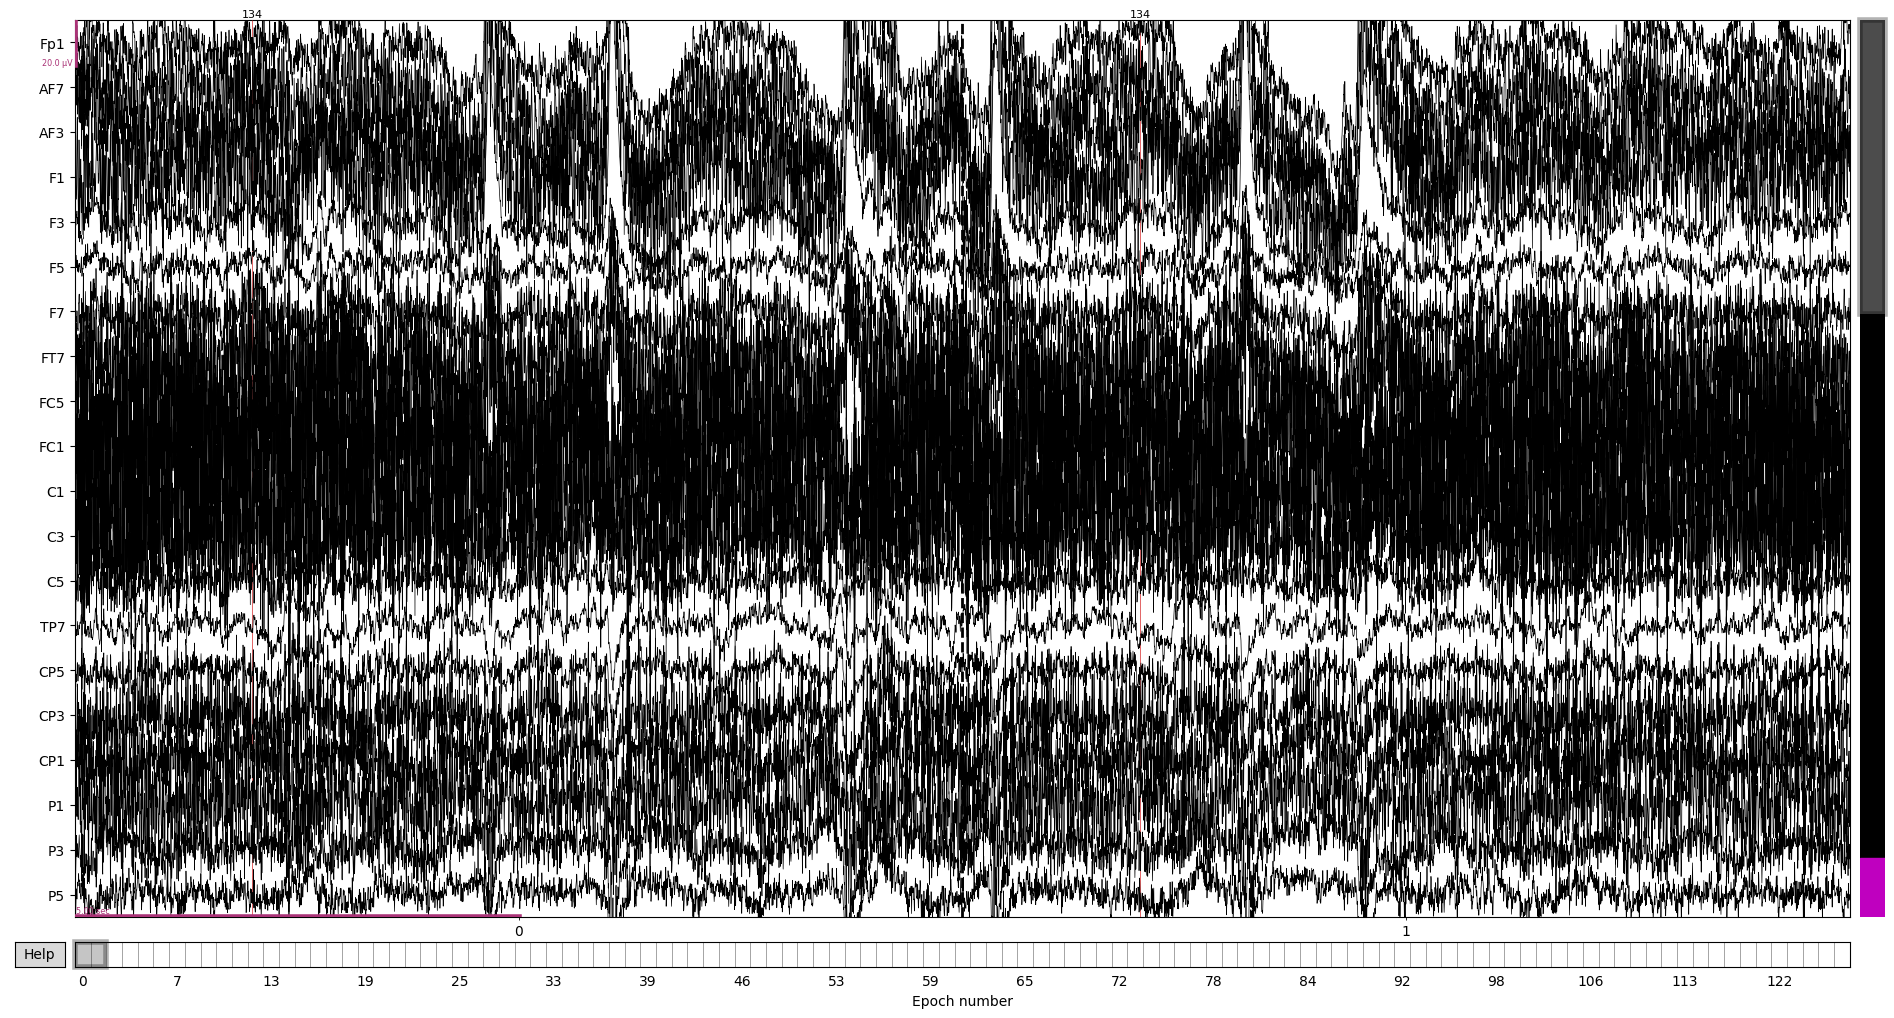

In [7]:
referenced.copy().filter(1,120, n_jobs=8).plot(n_channels=20, n_epochs=2, scalings=10e-6, events=referenced.events, picks=['eeg','ecg'])

EOG Regression

In [36]:
print()
emg_eog = ['EXG1','EXG2','EXG3','EXG4','EXG6','Fp2']
regressor = EOGRegression(
    picks='eeg', picks_artifact= emg_eog).fit(referenced)
regressor.plot()
referenced = regressor.apply(referenced)
referenced.info['bads'] += ['Fp2']


No projector specified for this dataset. Please consider the method self.add_proj.


No projector specified for this dataset. Please consider the method self.add_proj.


In [37]:
referenced.save('referenced_epo.fif', overwrite=True)
del referenced

Overwriting existing file.


REMOVE ARTIFACTS


In [60]:
epochs = read_epochs('referenced_epo.fif')
# epochs.drop([0, 2, 47, 54, 55, 57, 66])

Reading C:\Users\Alberto\Documents\BCI\data\mrl\referenced_epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    7999.02 ms
        0 CTF compensation matrices available
Not setting metadata
112 matching events found
No baseline correction applied
0 projection items activated


ICA

In [61]:
filtered = epochs['rest','left','right'].copy().filter(1,250, n_jobs=8)
filtered.apply_baseline((-1.5,-0.1))
filtered.crop(-1,1.8)
ica = ICA(n_components=10, method='picard')
ica.fit(filtered)

Setting up band-pass filter from 1 - 2.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 250.00 Hz
- Upper transition bandwidth: 62.50 Hz (-6 dB cutoff frequency: 281.25 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done 3152 tasks      | elapsed:    6.9s


Applying baseline correction (mode: mean)


[Parallel(n_jobs=8)]: Done 4032 out of 4032 | elapsed:    7.8s finished


Fitting ICA to data using 50 channels (please be patient, this may take a while)


C:\Users\Alberto\AppData\Local\Temp\ipykernel_10608\395878811.py:5: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(filtered)


Selecting by number: 10 components
Fitting ICA took 6.4s.


<ICA | epochs decomposition, method: picard (fit in 34 iterations on 180684 samples), 10 ICA components (50 PCA components available), channel types: eeg, no sources marked for exclusion>

In [40]:
plot_ica_components(ica)

[<MNEFigure size 975x496 with 10 Axes>]

C:\Users\Alberto\AppData\Local\Temp\ipykernel_10608\3695173692.py:2: RuntimeWarning: filter_length (3381) is longer than the signal (1946), distortion is likely. Reduce filter length or filter a longer signal.
  epochs['left','right'].copy().crop(-0.1,1.8).filter(1,120, verbose=False),


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
46 matching events found
No baseline correction applied
0 projection i

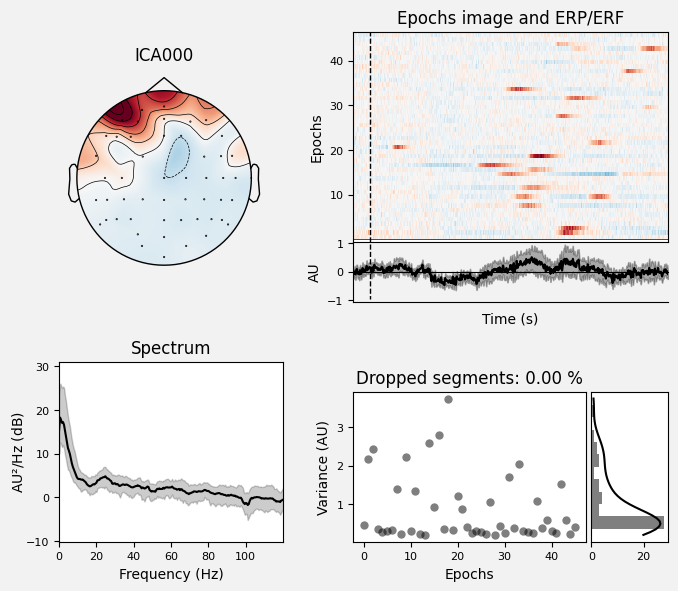

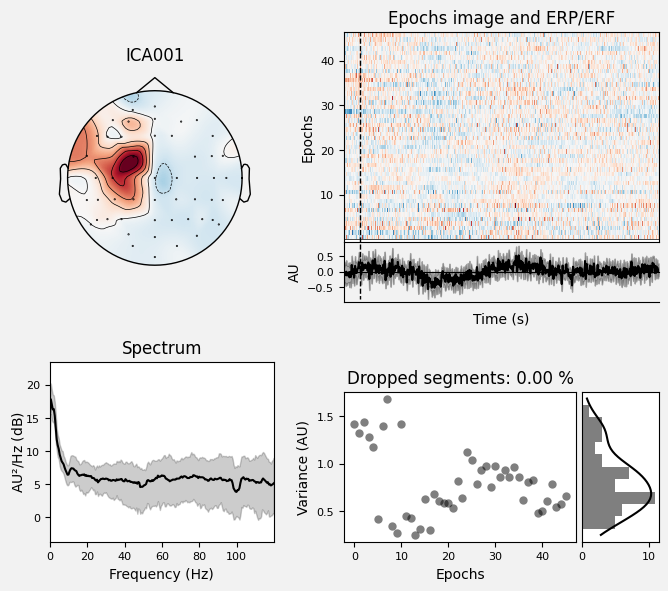

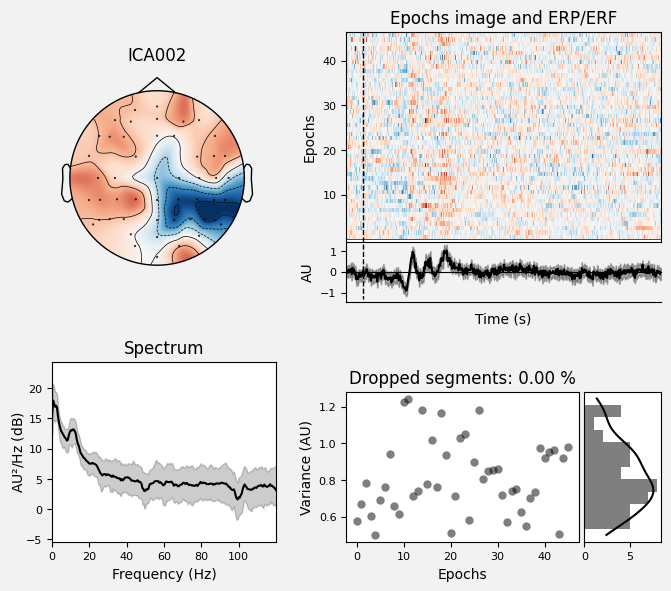

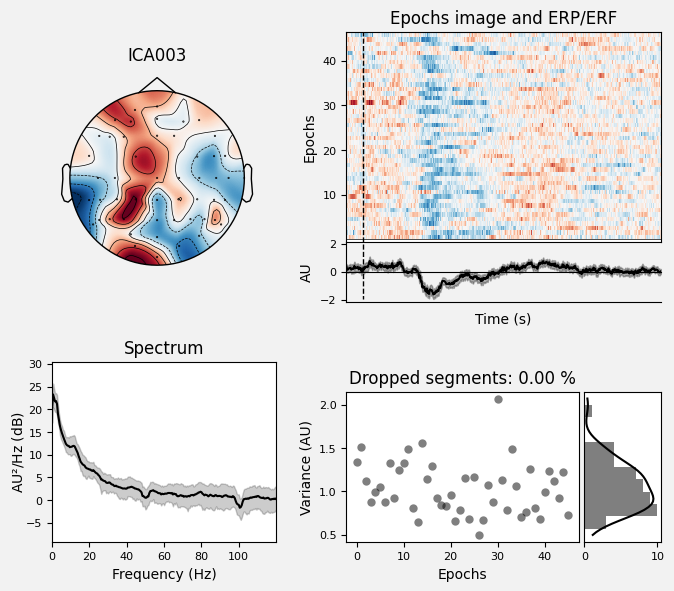

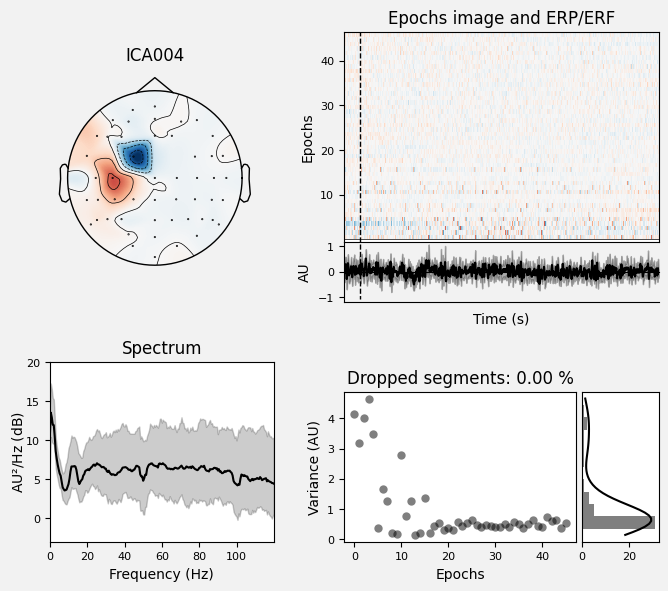

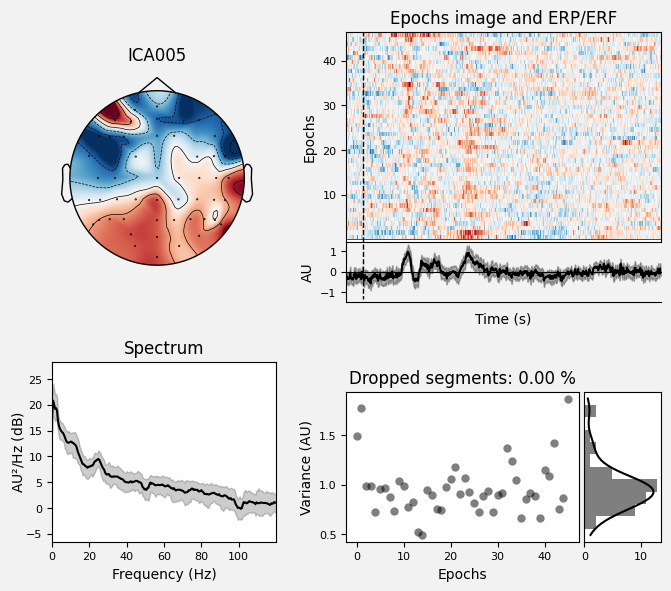

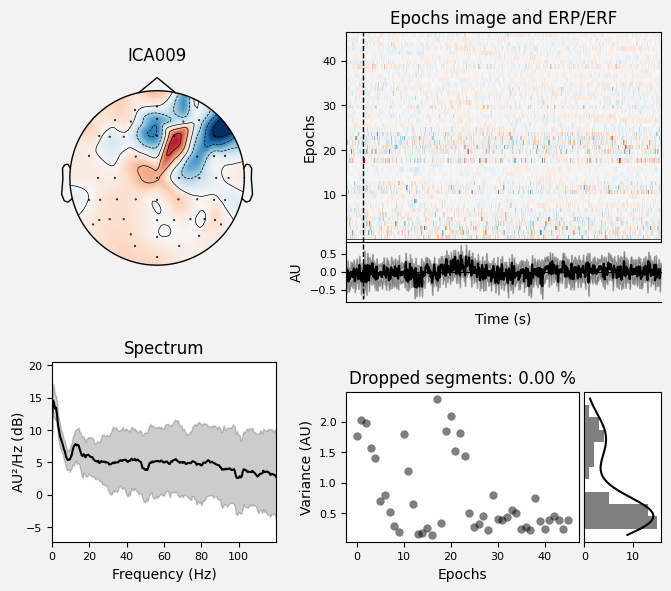

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [62]:
ica.plot_properties(
    epochs['left','right'].copy().crop(-0.1,1.8).filter(1,120, verbose=False), 
    picks = [0,1,2,3,4,5,6,7,8,9], 
    log_scale = False,
    psd_args = dict(fmax=120))

In [63]:
eog_indices, eog_scores = ica.find_bads_eog(
    filtered['left','right','rest'],
    ch_name= emg_eog, 
    measure='zscore',
    threshold=2)


Using EOG channels: EXG1, EXG2, EXG3, EXG4, EXG6, Fp2


In [45]:
eog_indices


[0, 3, 2]

In [64]:
ica.apply(epochs, exclude=np.unique([9,8,0,1]))

Applying ICA to Epochs instance
    Transforming to ICA space (10 components)
    Zeroing out 4 ICA components
    Projecting back using 50 PCA components


<EpochsFIF |  112 events (all good), -2 - 7.99902 sec, baseline off, ~638.9 MB, data loaded,
 'r_pinch': 25
 'r_stop': 24
 'left': 24
 'right': 22
 'rest': 17>

ERP

In [65]:
epochs['left','right'].copy().crop(-1,2).filter(1,120, n_jobs=8).average().plot()
print()

Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 3381 samples (3.302 sec)



C:\Users\Alberto\AppData\Local\Temp\ipykernel_10608\1697825411.py:1: RuntimeWarning: filter_length (3381) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  epochs['left','right'].copy().crop(-1,2).filter(1,120, n_jobs=8).average().plot()
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1689 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 2944 out of 2944 | elapsed:    2.0s finished


Setting up band-pass filter from 2 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 1691 samples (1.651 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 898 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1088 out of 1088 | elapsed:    0.4s finished


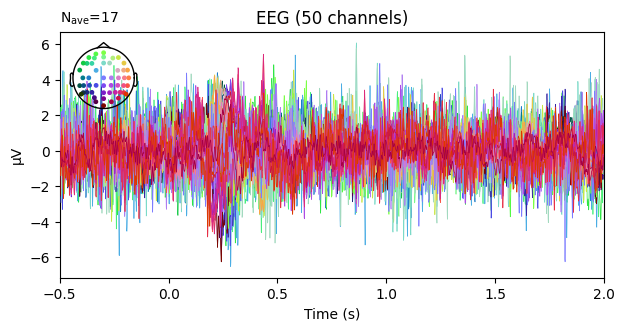

In [66]:
epochs['rest'].copy().crop(-0.5,2).filter(2,120, n_jobs=8).average().plot()
print()

In [67]:
le = LabelEncoder()
subset = epochs['left','rest'].copy()
subset.apply_baseline((-1.,-0.1))
subset.drop_channels(epochs.info['bads'])
subset = subset.pick(['eeg'])
y = le.fit_transform(subset.events[:,2])

Applying baseline correction (mode: mean)


In [68]:
pca = UnsupervisedSpatialFilter(PCA(len(subset.info['chs'])), average=False)
csp = CSP(n_components=2, reg=None, log=True, norm_trace=False, rank='info')
x = pca.fit_transform(subset.copy().crop(-0.1,2).filter(5, 20, n_jobs=4, verbose=False).get_data(),y)

Computing rank from data with rank='info'
    MAG: rank 50 after 0 projectors applied to 50 channels
Reducing data rank from 50 -> 50
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 50 after 0 projectors applied to 50 channels
Reducing data rank from 50 -> 50
Estimating covariance using EMPIRICAL
Done.


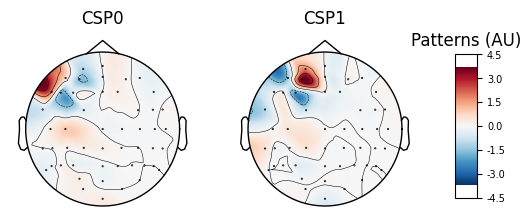

In [69]:
x = pca.fit_transform(subset.copy().crop(-0.1,2).filter(5, 20, n_jobs=4, verbose=False).get_data(),y)
csp.fit(x,y)
csp.plot_patterns(subset.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
print()

In [70]:
x = pca.fit_transform(subset.copy().crop(-0.1,2).filter(20, 35, n_jobs=4, verbose=False).get_data(),y)
csp.fit(x,y)
csp.plot_patterns(subset.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
print()

Computing rank from data with rank='info'
    MAG: rank 50 after 0 projectors applied to 50 channels
Reducing data rank from 50 -> 50
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 50 after 0 projectors applied to 50 channels
Reducing data rank from 50 -> 50
Estimating covariance using EMPIRICAL
Done.


Computing rank from data with rank='info'
    MAG: rank 50 after 0 projectors applied to 50 channels
Reducing data rank from 50 -> 50
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 50 after 0 projectors applied to 50 channels
Reducing data rank from 50 -> 50
Estimating covariance using EMPIRICAL
Done.


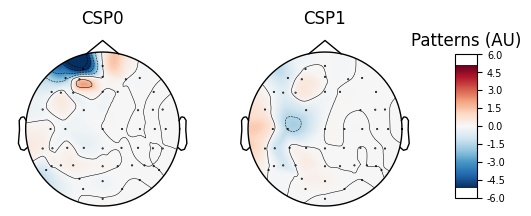

In [71]:
x = pca.fit_transform(subset.copy().crop(-0.1,1.8).filter(70, 90, n_jobs=4, verbose=False).get_data(),y)
csp.fit(x,y)
csp.plot_patterns(subset.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
print()

In [72]:
epochs.save('ica_epo.fif', overwrite=True)

Overwriting existing file.
